# Single photon & linear optics: Phase estimation

In [37]:
import itertools

import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
from rich.pretty import pprint

from squint.circuit import Circuit
from squint.ops.fock import BeamSplitter, FockState, Phase

In [41]:
cut = 4  # Fock cutoff
circuit = Circuit(backend="pure")
circuit.add(FockState(wires=(0,), n=(1,)))
circuit.add(FockState(wires=(1,), n=(1,)))

circuit.add(
    BeamSplitter(
        wires=(
            0,
            1,
        ),
        r=jnp.pi / 4,
    )
)
circuit.add(Phase(wires=(0,), phi=0.1 * jnp.pi), "phase")
circuit.add(
    BeamSplitter(
        wires=(
            0,
            1,
        ),
        r=jnp.pi / 4,
    )
)
pprint(circuit)

Circuit(
  dims=None,
  ops={
│   0:
│   FockState(wires=(0,), n=[(1.0, (1,))]),
│   1:
│   FockState(wires=(1,), n=[(1.0, (1,))]),
│   2:
│   BeamSplitter(wires=(0, 1), r=weak_f64[]),
│   'phase':
│   Phase(wires=(0,), phi=weak_f64[]),
│   4:
│   BeamSplitter(wires=(0, 1), r=weak_f64[])
  },
  _backend='pure'
)

In [43]:
params, static = eqx.partition(circuit, eqx.is_inexact_array)
sim = circuit.compile(params, static, dim=cut, optimize="greedy").jit()
get = lambda pytree: jnp.array([pytree.ops["phase"].phi])

In [44]:
sim.probabilities.forward(params).sum()

Array(0.9999998, dtype=float32)

In [45]:
phis = jnp.linspace(-jnp.pi, jnp.pi, 100)


def update(phi, params):
    return eqx.tree_at(lambda pytree: pytree.ops["phase"].phi, params, phi)


probs = jax.lax.map(lambda phi: sim.probabilities.forward(update(phi, params)), phis)
qfims = jax.lax.map(lambda phi: sim.amplitudes.qfim(get, update(phi, params)), phis)
cfims = jax.lax.map(lambda phi: sim.probabilities.cfim(get, update(phi, params)), phis)

[Text(0.5, 0, 'Phase, $\\varphi$'),
 Text(0, 0.5, '$\\mathcal{I}_\\varphi^C$'),
 (0.0, 4.200001172595594)]

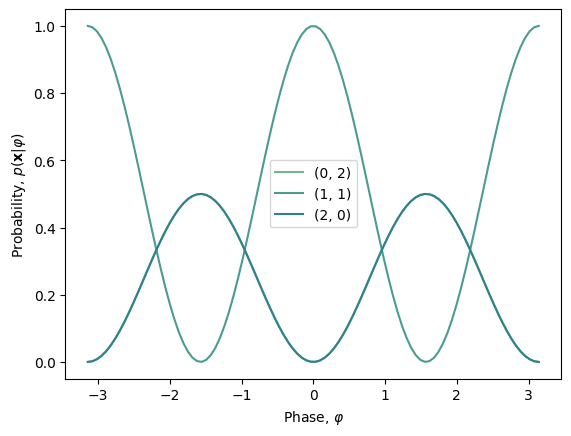

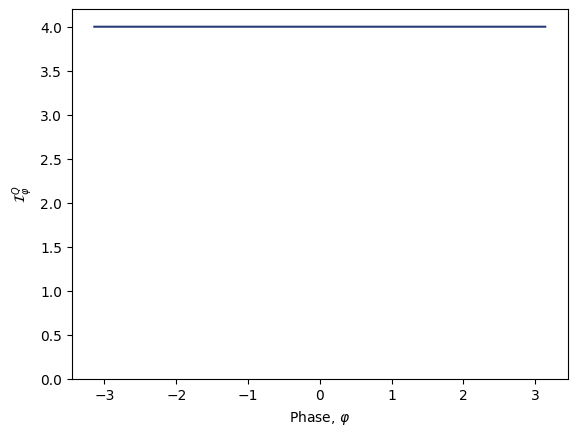

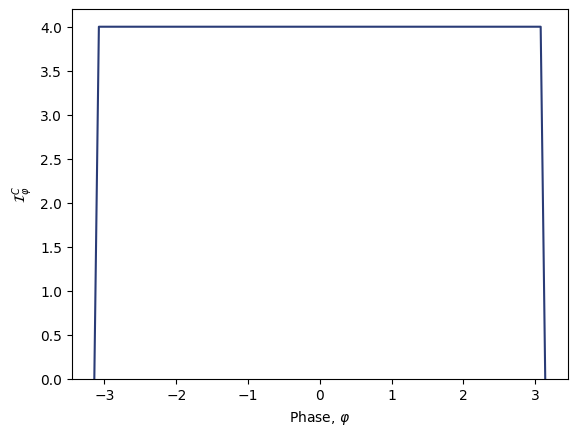

In [47]:
colors = sns.color_palette("crest", n_colors=jnp.prod(jnp.array(probs.shape[1:])))
fig, ax = plt.subplots()
for i, idx in enumerate(
    itertools.product(*[list(range(ell)) for ell in probs.shape[1:]])
):
    if jnp.mean(probs[:, *idx]) < 1e-10:
        continue
    ax.plot(phis, probs[:, *idx], label=f"{idx}", color=colors[i])
ax.legend()
ax.set(xlabel=r"Phase, $\varphi$", ylabel=r"Probability, $p(\mathbf{x} | \varphi)$")


fig, ax = plt.subplots()
ax.plot(phis, qfims.squeeze(), color=colors[i])
ax.set(
    xlabel=r"Phase, $\varphi$",
    ylabel=r"$\mathcal{I}_\varphi^Q$",
    ylim=[0, 1.05 * jnp.max(qfims)],
)

fig, ax = plt.subplots()
ax.plot(phis, cfims.squeeze(), color=colors[i])
ax.set(
    xlabel=r"Phase, $\varphi$",
    ylabel=r"$\mathcal{I}_\varphi^C$",
    ylim=[0, 1.05 * jnp.max(cfims)],
)